In [1]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=7e8c75ff6ecbc86370299bd2cd0cc2eeb29fbc6288adf4122ce0aef1f405ec20
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=c3ceea522f77f8fcef63c75afafe9ff4ddd014b3e9960fc3f7c3f191493439aa
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


Importing libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import requests
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from shutil import copyfile
import os

In [ ]:
os.chdir('/content/drive/My Drive/MLDL_project')
from models.bisenet.build_bisenet import BiSeNet
from utils import fast_hist
from utils import per_class_iou
from utils import poly_lr_scheduler
from utils import latency_fps
from train import train
from validate import validation
import time
from torch.utils.data import RandomSampler
from timeit import default_timer as timer
from fvcore.nn import FlopCountAnalysis, flop_count_table

In [ ]:
from datasets.cityscapes import CityscapesDataset
from datasets.gta5 import GTA5

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

Defining dataloaders

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_lbl_transform = transforms.Compose([
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_lbl_transform = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

In [ ]:
train_dataset = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform,train_lbl_transform]) # datasets\\GTA5
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', split='val', transform=[val_transform,val_lbl_transform]) # datasets\\Cityscapes\\Cityspaces

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers = 8) #16
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers = 8) #16

In [ ]:
train_dataset = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5') # datasets\\GTA5
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', split='val') # datasets\\Cityscapes\\Cityspaces

Quick checking

In [ ]:
for images, labels in train_dataloader:
    # Access the first image and label
    image, label = images[0], labels[0]
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Label:", label)

    break

Image shape: torch.Size([3, 720, 1280])
Label shape: torch.Size([720, 1280])
Label: tensor([[ 10,  10,  10,  ...,  10,  10,  10],
        [ 10,  10,  10,  ...,  10,  10,  10],
        [ 10,  10,  10,  ...,  10,  10,  10],
        ...,
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255]])


In [ ]:
for images, labels in val_dataloader:
    # Access the first image and label
    image, label = images[0], labels[0]
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    print("Label:", label)

    break

Image shape: torch.Size([3, 512, 1024])
Label shape: torch.Size([512, 1024])
Label: tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])


Importing model

In [ ]:
# Load pre-trained mo
# del
bisenet = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.2MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 236MB/s]


In [ ]:
bisenet

BiSeNet(
  (saptial_path): Spatial_path(
    (convblock1): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (convblock3): ConvBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (context_path): resnet18(
    (features): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Training and validation process

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
initial_lr = 2.5e-2
optimizer = torch.optim.SGD(bisenet.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list = []
miou_val_list = []
miou_per_class_train_list = []
miou_per_class_val_list = []
models = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")
    train_loss, train_miou, train_miou_per_class = train(ep, bisenet, train_dataloader, loss_fn, optimizer)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet, val_dataloader, loss_fn)
      miou_train_list.append(train_miou)
      miou_val_list.append(val_miou)
      miou_per_class_train_list.append(train_miou_per_class)
      miou_per_class_val_list.append(val_miou_per_class)
      models.append(bisenet.state_dict())

    print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet, val_dataloader, loss_fn)
miou_train_list.append(train_miou)
miou_val_list.append(val_miou)
miou_per_class_train_list.append(train_miou_per_class)
miou_per_class_val_list.append(val_miou_per_class)
models.append(bisenet.state_dict())


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rate: 0.025
Epoch1 Avg. Training Loss: 0.4591260942312094, mIoU: 0.28438149261314116
Avg. Validation Loss: 1.3103099522136508, mIoU: 0.18253438020217203


Current learning rate: 0.025
Epoch2 Avg. Training Loss: 0.27726153734202585, mIoU: 0.41347744598332187


Current learning rate: 0.024549546664914382
Epoch3 Avg. Training Loss: 0.22334589030795965, mIoU: 0.49697404937556666


Current learning rate: 0.024098173031463777
Epoch4 Avg. Training Loss: 0.1990298449326628, mIoU: 0.5596250523043501


Current learning rate: 0.023645857984465803
Epoch5 Avg. Training Loss: 0.17785379876153537, mIoU: 0.593118220941513


Current learning rate: 0.023192579464083207
Epoch6 Avg. Training Loss: 0.16626373076210388, mIoU: 0.6130379537843469
Avg. Validation Loss: 1.874833933890812, mIoU: 0.18845439012070844


Current learning rate: 0.022738314402074057
Epoch7 Avg. Training Loss: 0.1541159662623375, mIoU: 0.6375066737119187


Current learning rate: 0.022283038652225
Epoch8 Avg. Training L

In [ ]:
# save best model
import os
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3a_epoch{epochs}_batchsize8.pth'

# delete old model files
if os.path.exists(PATH):
    os.remove(PATH)

best_bisenet = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet.load_state_dict(models[np.argmax(np.array(miou_val_list))])
torch.save(best_bisenet.state_dict(), PATH)

In [ ]:
print(miou_per_class_train_list[-1])

[0.9907819  0.89681996 0.92048953 0.86506423 0.71712534 0.56806882
 0.59378385 0.72166179 0.84671841 0.85668833 0.96152719 0.5844759
 0.63043698 0.92846527 0.93092468 0.95811755 0.94418544 0.74907785
 0.5317319 ]


In [ ]:
print(miou_per_class_val_list[-1])

[0.58980972 0.08539778 0.63221385 0.08850039 0.03451512 0.1380125
 0.1283131  0.09317193 0.75576652 0.10885491 0.55965135 0.39023413
 0.00505997 0.356723   0.07409048 0.0548812  0.0398205  0.01619117
 0.0019894 ]


In [ ]:
print(miou_per_class_train_list[np.argmax(np.array(miou_val_list))])

[0.9907819  0.89681996 0.92048953 0.86506423 0.71712534 0.56806882
 0.59378385 0.72166179 0.84671841 0.85668833 0.96152719 0.5844759
 0.63043698 0.92846527 0.93092468 0.95811755 0.94418544 0.74907785
 0.5317319 ]


In [ ]:
print(miou_per_class_val_list[np.argmax(np.array(miou_val_list))])

[0.58980972 0.08539778 0.63221385 0.08850039 0.03451512 0.1380125
 0.1283131  0.09317193 0.75576652 0.10885491 0.55965135 0.39023413
 0.00505997 0.356723   0.07409048 0.0548812  0.0398205  0.01619117
 0.0019894 ]


In [ ]:
# train_dataset.classes
classes = [ "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "light",
            "sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motocycle",
            "bicycle",
        ]

In [ ]:
train_dataset.classes_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
miou_train_list = [0.2843814926,	0.6130379538,	0.7014793928,	0.7400503365,	0.7591103036,	0.7728744896,	0.7824743787,	0.7896636512,	0.7964850344,	0.7988911134,	0.7997971013]
miou_val_list = [0.1825343802,	0.1884543901,	0.1884476331,	0.2078570696,	0.2103402587,	0.2057267895,	0.2118899025,	0.2124195931,	0.210671112,	0.2147675754,	0.2185893155]

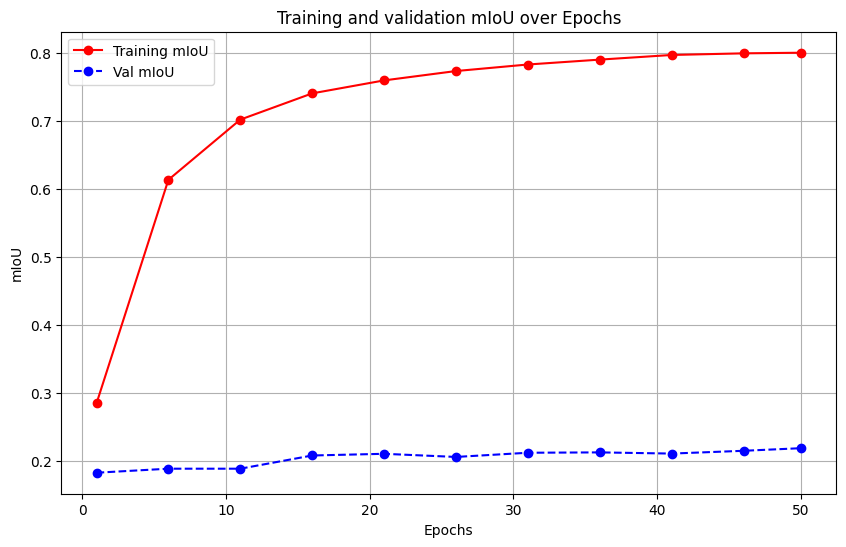

In [ ]:
import matplotlib.pyplot as plt

epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

Latency and FPS | FLOPs and parameters

In [ ]:
bisenet.eval()

In [ ]:
# Latency and FPS

latency_fps(model = bisenet, train_dataset = train_dataset, transform = train_transform, device = 'cuda', iterations = 1000)

In [ ]:
# FLOPs and parameters

height, width = 512, 1024
image = torch.zeros((3, height, width))

flops = FlopCountAnalysis(bisenet, image)
print(flop_count_table(flops))

If we want to plot segmentation results on GTA5 images:

In [ ]:
from datasets.gta5Labels import GTA5Labels_TaskCV2017


def convert_model_output_to_rgb(model_output):

    model_output = torch.argmax(model_output, dim=1)
    model_output = model_output.squeeze(0)

    label_converter = GTA5Labels_TaskCV2017()
    h, w = model_output.shape
    rgb_output = np.zeros((h, w, 3))

    for i in range(h):
        for j in range(w):
            ID = int(model_output[i, j].item())
            rgb_output[i, j] = label_converter.trans_id_to_rgb().get(ID, (0, 0, 0)) # black for 255 ID

    return rgb_output.astype(int)

In [ ]:
label_converter = GTA5Labels_TaskCV2017()
label_converter.trans_id_to_rgb().get(7, (0,0,0))

(220, 220, 0)

In [ ]:
epochs = 50
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
PATH = DIR + f'bisenet3b_aug2_epoch50_batchsize8.pth'
best_bisenet = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
best_bisenet.eval()

data_iter = iter(val_dataloader)
inputs, _ = next(data_iter)
input_image = inputs[0].unsqueeze(0).cuda()

with torch.no_grad():
    output = best_bisenet(input_image)

print(output.shape)

torch.Size([1, 19, 512, 1024])


In [ ]:
rgb_output = convert_model_output_to_rgb(output)

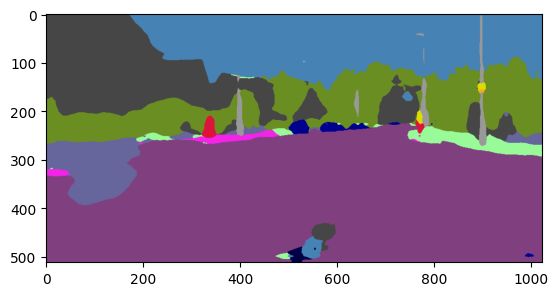

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(rgb_output)
plt.show()

#### Data Augmentation

In [ ]:
import os
import matplotlib.pyplot as plt

Defining transformations

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
train_transform_aug1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.RandomInvert()], p=0.5),
    transforms.Resize((720, 1280), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_aug2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.5),
    transforms.Resize((720, 1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_aug3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5),
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_aug4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5), # increase sharpness
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_aug5 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0, 0.05)], p=0.5),
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_lbl_transform = transforms.Compose([
    transforms.Resize((720,1280), interpolation=Image.Resampling.NEAREST),
])

In [ ]:
# # combination of augmentations 2 and 5
train_transform_aug25 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1), AddGaussianNoise(0, 0.05)], p=0.5),
    transforms.Resize((720, 1280), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_lbl_transform = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

Defining dataloaders

In [ ]:
train_dataset1 = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug1,train_lbl_transform]) # datasets\\GTA5
train_dataset2 = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug2,train_lbl_transform]) # datasets\\GTA5
train_dataset3 = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug3,train_lbl_transform]) # datasets\\GTA5
train_dataset4 = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug4,train_lbl_transform]) # datasets\\GTA5
train_dataset5 = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug5,train_lbl_transform]) # datasets\\GTA5
train_dataset25 = GTA5('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[train_transform_aug25,train_lbl_transform]) # datasets\\GTA5
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', split='val', transform=[val_transform,val_lbl_transform]) # datasets\\Cityscapes\\Cityspaces

train_dataloader1 = DataLoader(train_dataset1, batch_size=4, shuffle=True, num_workers = 8) #16
train_dataloader2 = DataLoader(train_dataset2, batch_size=4, shuffle=True, num_workers = 8) #16
train_dataloader3 = DataLoader(train_dataset3, batch_size=4, shuffle=True, num_workers = 8) #16
train_dataloader4 = DataLoader(train_dataset4, batch_size=4, shuffle=True, num_workers = 8) #16
train_dataloader5 = DataLoader(train_dataset5, batch_size=4, shuffle=True, num_workers = 8) #16
train_dataloader25 = DataLoader(train_dataset25, batch_size=4, shuffle=True, num_workers = 8) #16
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers = 8) #16

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Performing the augmentations

In [ ]:
# Define loss and initial learning rate
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
initial_lr = 2.5e-2

aug1

In [ ]:
bisenet_aug1 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

# Define optimizer
optimizer_aug1 = torch.optim.SGD(bisenet_aug1.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list_aug1 = []
miou_val_list_aug1 = []
miou_per_class_train_list_aug1 = []
miou_per_class_val_list_aug1 = []
models_aug1 = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")

    train_loss, train_miou, train_miou_per_class = train(ep, bisenet_aug1, train_dataloader1, loss_fn, optimizer_aug1)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer_aug1, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet_aug1, val_dataloader, loss_fn)
      miou_train_list_aug1.append(train_miou)
      miou_val_list_aug1.append(val_miou)
      miou_per_class_train_list_aug1.append(train_miou_per_class)
      miou_per_class_val_list_aug1.append(val_miou_per_class)
      models_aug1.append(bisenet_aug1.state_dict())

    print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet_aug1, val_dataloader, loss_fn)
miou_train_list_aug1.append(train_miou)
miou_val_list_aug1.append(val_miou)
miou_per_class_train_list_aug1.append(train_miou_per_class)
miou_per_class_val_list_aug1.append(val_miou_per_class)
models_aug1.append(bisenet_aug1.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rate: 0.025
Epoch1 Avg. Training Loss: 0.49560905747413636, mIoU: 0.2796499146273748
Avg. Validation Loss: 2.6038895769119264, mIoU: 0.11330662766899251


Current learning rate: 0.025
Epoch2 Avg. Training Loss: 0.3100408433198929, mIoU: 0.3932673515414484


Current learning rate: 0.024549546664914382
Epoch3 Avg. Training Loss: 0.263365704369545, mIoU: 0.4591160893316435


Current learning rate: 0.024098173031463777
Epoch4 Avg. Training Loss: 0.22781228332519532, mIoU: 0.5128847583835641


Current learning rate: 0.023645857984465803
Epoch5 Avg. Training Loss: 0.19600662153959275, mIoU: 0.578329126428779


Current learning rate: 0.023192579464083207
Epoch6 Avg. Training Loss: 0.18299489456415177, mIoU: 0.6081317465871635
Avg. Validation Loss: 1.632393886566162, mIoU: 0.19350630093365084


Current learning rate: 0.022738314402074057
Epoch7 Avg. Training Loss: 0.18026818158626556, mIoU: 0.6149313149097926


Current learning rate: 0.022283038652225
Epoch8 Avg. Training Loss

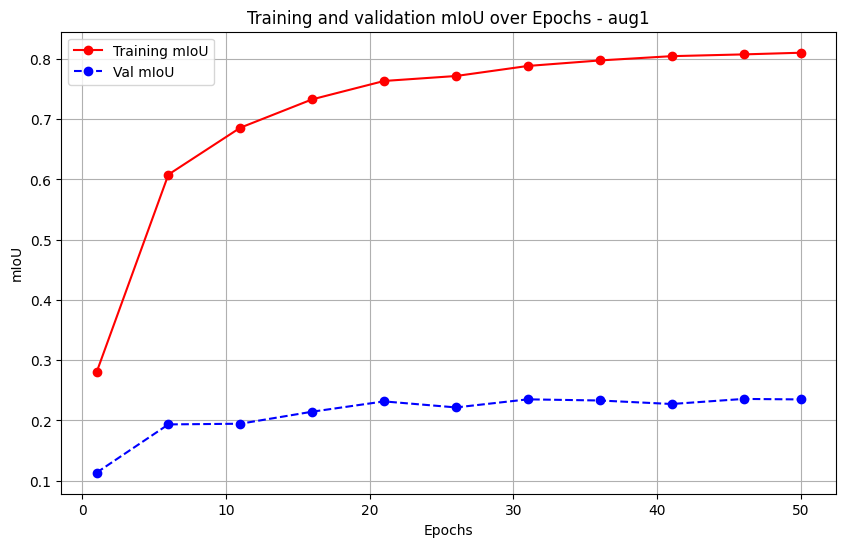

In [ ]:
# save best model
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3b_aug1_epoch{epochs}_batchsize8.pth'

if os.path.exists(PATH):
    os.remove(PATH) # delete old model files

best_bisenet_aug1 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet_aug1.load_state_dict(models_aug1[np.argmax(np.array(miou_val_list_aug1))])
torch.save(best_bisenet_aug1.state_dict(), PATH)


# print miou evolution
epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list_aug1, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list_aug1, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs - aug1')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(miou_per_class_val_list_aug1[-1])

[0.62638325 0.16022198 0.64963414 0.111166   0.08881853 0.17502006
 0.09390878 0.06603231 0.7780265  0.10352061 0.56771389 0.36880658
 0.00846595 0.49548137 0.07217512 0.04493763 0.03268139 0.01644145
 0.00463136]


In [ ]:
print(miou_per_class_train_list_aug1[-1])

[0.99139428 0.90279813 0.92356164 0.87355467 0.73186216 0.58300626
 0.59091171 0.73237719 0.84800293 0.8607842  0.96056695 0.60889736
 0.66945265 0.93226507 0.93503821 0.96106017 0.9486866  0.77482728
 0.56773905]


In [ ]:
print(miou_per_class_val_list_aug1[np.argmax(np.array(miou_val_list_aug1))])

[0.65032235 0.16316793 0.65781876 0.11832931 0.08914702 0.16622847
 0.09304678 0.0626874  0.77892897 0.11445321 0.56686802 0.36729555
 0.0043804  0.51762007 0.05810969 0.0325083  0.02434534 0.01164661
 0.00277272]


In [ ]:
print(miou_per_class_train_list_aug1[np.argmax(np.array(miou_val_list_aug1))])

[0.99121174 0.90072558 0.92274728 0.87039423 0.72653449 0.5803666
 0.58614831 0.72564579 0.84705683 0.85944178 0.96050606 0.60370038
 0.66435695 0.9313623  0.93344982 0.96143999 0.94638561 0.76875588
 0.56382022]


aug2

In [ ]:
## Transforming the images and saving them on a folder

# from torchvision.utils import save_image

# train_dataloader2t = DataLoader(train_dataset2, batch_size=4, shuffle=False, num_workers = 8)

# output_folder = '/content/drive/MyDrive/MLDL_project/datasets/GTA5/images_aug2'
# os.makedirs(output_folder, exist_ok=True)

# file_counter = 1

# for i, (images, _) in enumerate(train_dataloader2t):

#     # to process all the images within a batch
#     for j in range(images.size(0)):

#         img = images[j]

#         filename = f'{file_counter:05}.png'
#         output_path = os.path.join(output_folder, filename)

#         save_image(img, output_path)

#         file_counter += 1

# print('All images have been transformed and saved.')

All images have been transformed and saved.


In [ ]:
# from datasets.gta5_aug2 import GTA5_aug2
# tensor_transform = transforms.ToTensor()
# train_dataset2 = GTA5_aug2('/content/drive/MyDrive/MLDL_project/datasets/GTA5', transform=[tensor_transform,train_lbl_transform], img_dir_name = 'images_aug2')
# train_dataloader2 = DataLoader(train_dataset2, batch_size=4, shuffle=True, num_workers = 8)

In [ ]:
bisenet_aug2 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

# Define optimizer
optimizer_aug2 = torch.optim.SGD(bisenet_aug2.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list_aug2 = []
miou_val_list_aug2 = []
miou_per_class_train_list_aug2 = []
miou_per_class_val_list_aug2 = []
models_aug2 = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")

    train_loss, train_miou, train_miou_per_class = train(ep, bisenet_aug2, train_dataloader2, loss_fn, optimizer_aug2)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer_aug2, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet_aug2, val_dataloader, loss_fn)
      miou_train_list_aug2.append(train_miou)
      miou_val_list_aug2.append(val_miou)
      miou_per_class_train_list_aug2.append(train_miou_per_class)
      miou_per_class_val_list_aug2.append(val_miou_per_class)
      models_aug2.append(bisenet_aug2.state_dict())

    print("\n")


# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet_aug2, val_dataloader, loss_fn)
miou_train_list_aug2.append(train_miou)
miou_val_list_aug2.append(val_miou)
miou_per_class_train_list_aug2.append(train_miou_per_class)
miou_per_class_val_list_aug2.append(val_miou_per_class)
models_aug2.append(bisenet_aug2.state_dict())


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rate: 0.025
Epoch1 Avg. Training Loss: 0.4842874769687653, mIoU: 0.2797272914624187
Avg. Validation Loss: 1.4397033381462097, mIoU: 0.16647135935467955


Current learning rate: 0.025
Epoch2 Avg. Training Loss: 0.3034692564725876, mIoU: 0.3939171656097789


Current learning rate: 0.024549546664914382
Epoch3 Avg. Training Loss: 0.2574022871732712, mIoU: 0.4564715181769518


Current learning rate: 0.024098173031463777
Epoch4 Avg. Training Loss: 0.21601145622730256, mIoU: 0.518875841993157


Current learning rate: 0.023645857984465803
Epoch5 Avg. Training Loss: 0.20302006412744522, mIoU: 0.5623886722629484


Current learning rate: 0.023192579464083207
Epoch6 Avg. Training Loss: 0.17858783749341964, mIoU: 0.6110093369125513
Avg. Validation Loss: 0.7209174814224243, mIoU: 0.2759139320456076


Current learning rate: 0.022738314402074057
Epoch7 Avg. Training Loss: 0.16939807493686676, mIoU: 0.6365933376878811


Current learning rate: 0.022283038652225
Epoch8 Avg. Training Loss

In [ ]:
# save best model
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3b_aug2_epoch{epochs}_batchsize8.pth'

if os.path.exists(PATH):
    os.remove(PATH) # delete old model files

best_bisenet_aug2 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet_aug2.load_state_dict(models_aug2[np.argmax(np.array(miou_val_list_aug2))])
torch.save(best_bisenet_aug2.state_dict(), PATH)

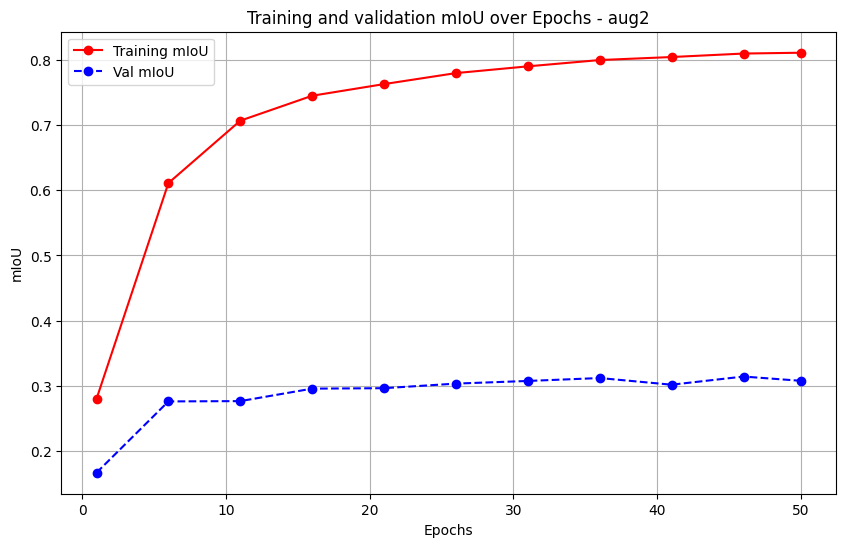

In [ ]:
# print miou evolution
epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list_aug2, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list_aug2, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs - aug2')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(miou_per_class_val_list_aug2[-1])

[8.28282854e-01 2.45420244e-01 7.28616841e-01 2.07033089e-01
 1.06112321e-01 2.14360316e-01 1.57155295e-01 7.35935461e-02
 7.74481082e-01 1.79471316e-01 7.19370604e-01 4.08199274e-01
 7.74525753e-02 7.19187022e-01 1.81924347e-01 1.18687742e-01
 2.35424562e-04 7.20554583e-02 3.14468668e-02]


In [ ]:
print(miou_per_class_train_list_aug2[-1])

[0.99127295 0.90151657 0.92296317 0.87234992 0.72946307 0.58740598
 0.60951864 0.73674214 0.85191734 0.85815925 0.96074268 0.61174277
 0.68151092 0.93377598 0.93581357 0.95831599 0.94698948 0.77815232
 0.54230294]


In [ ]:
print(miou_per_class_val_list_aug2[np.argmax(np.array(miou_val_list_aug2))])

[0.83628703 0.2503569  0.74191034 0.21872322 0.11255936 0.2236206
 0.16268497 0.07216535 0.77557284 0.15665093 0.7538315  0.40515039
 0.08234611 0.72576795 0.21177635 0.13134576 0.         0.06804606
 0.03885756]


In [ ]:
print(miou_per_class_train_list_aug2[np.argmax(np.array(miou_val_list_aug2))])

[0.99112688 0.89990152 0.92212982 0.86937665 0.72561055 0.58556502
 0.60783747 0.73510465 0.85039747 0.85460601 0.96050677 0.60796054
 0.68160586 0.9324884  0.93412299 0.96135524 0.94608105 0.77210129
 0.54868274]


aug3

In [ ]:
bisenet_aug3 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

# Define optimizer
optimizer_aug3 = torch.optim.SGD(bisenet_aug3.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list_aug3 = []
miou_val_list_aug3 = []
miou_per_class_train_list_aug3 = []
miou_per_class_val_list_aug3 = []
models_aug3 = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")

    train_loss, train_miou, train_miou_per_class = train(ep, bisenet_aug3, train_dataloader3, loss_fn, optimizer_aug3)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer_aug3, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet_aug3, val_dataloader, loss_fn)
      miou_train_list_aug3.append(train_miou)
      miou_val_list_aug3.append(val_miou)
      miou_per_class_train_list_aug3.append(train_miou_per_class)
      miou_per_class_val_list_aug3.append(val_miou_per_class)
      models_aug3.append(bisenet_aug3.state_dict())

    print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet_aug3, val_dataloader, loss_fn)
miou_train_list_aug3.append(train_miou)
miou_val_list_aug3.append(val_miou)
miou_per_class_train_list_aug3.append(train_miou_per_class)
miou_per_class_val_list_aug3.append(val_miou_per_class)
models_aug3.append(bisenet_aug3.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rate: 0.025
Epoch1 Avg. Training Loss: 0.4766099646091461, mIoU: 0.2789168917410225
Avg. Validation Loss: 1.3043893494606018, mIoU: 0.1805188043516798


Current learning rate: 0.025
Epoch2 Avg. Training Loss: 0.29129158897399904, mIoU: 0.41265564884994704


Current learning rate: 0.024549546664914382
Epoch3 Avg. Training Loss: 0.23634921209812165, mIoU: 0.5055101628677439


Current learning rate: 0.024098173031463777
Epoch4 Avg. Training Loss: 0.20540024002790452, mIoU: 0.5479310051725946


Current learning rate: 0.023645857984465803
Epoch5 Avg. Training Loss: 0.17788301575183868, mIoU: 0.5960817306064491


Current learning rate: 0.023192579464083207
Epoch6 Avg. Training Loss: 0.1638500604391098, mIoU: 0.6208917741575334
Avg. Validation Loss: 2.3522786989212037, mIoU: 0.19057518771402826


Current learning rate: 0.022738314402074057
Epoch7 Avg. Training Loss: 0.16038636277914048, mIoU: 0.6301479674796756


Current learning rate: 0.022283038652225
Epoch8 Avg. Training L

In [ ]:
# save best model
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3b_aug3_epoch{epochs}_batchsize8.pth'

if os.path.exists(PATH):
    os.remove(PATH) # delete old model files

best_bisenet_aug3 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet_aug3.load_state_dict(models_aug3[np.argmax(np.array(miou_val_list_aug3))])
torch.save(best_bisenet_aug3.state_dict(), PATH)

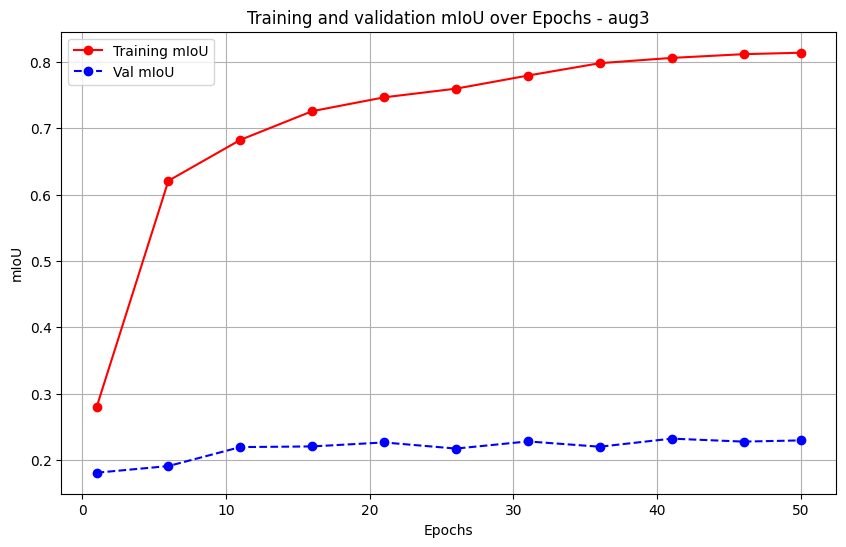

In [ ]:
# print miou evolution
epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list_aug3, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list_aug3, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs - aug3')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(miou_per_class_val_list_aug3[-1])

[0.44599301 0.12393227 0.69212136 0.11444222 0.15186277 0.20433096
 0.14967813 0.07010938 0.77118789 0.07615236 0.69366158 0.37271819
 0.07159843 0.31526028 0.03015572 0.01928022 0.         0.04644982
 0.00741068]


In [ ]:
print(miou_per_class_train_list_aug3[-1])

[0.99172474 0.9075001  0.92722821 0.879312   0.73375475 0.59882618
 0.63805857 0.75848481 0.85607708 0.86867643 0.9637387  0.62612944
 0.66158118 0.93584561 0.93873087 0.96293075 0.94990306 0.76944367
 0.49871995]


In [ ]:
print(miou_per_class_val_list_aug3[np.argmax(np.array(miou_val_list_aug3))])

[0.43551281 0.11799604 0.70152234 0.11154469 0.14453528 0.211023
 0.16067847 0.06766952 0.77329685 0.05743494 0.69546415 0.37883105
 0.07439837 0.34774344 0.0329666  0.01789401 0.         0.07265284
 0.00589652]


In [ ]:
print(miou_per_class_train_list_aug3[np.argmax(np.array(miou_val_list_aug3))])

[0.99128124 0.90250963 0.92451714 0.87082902 0.72199499 0.5910628
 0.62635717 0.74619934 0.85285444 0.86289017 0.96330479 0.6172329
 0.64442815 0.93307326 0.93568093 0.959665   0.94691048 0.75951805
 0.46765825]


aug4

In [ ]:
bisenet_aug4 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

# Define optimizer
optimizer_aug4 = torch.optim.SGD(bisenet_aug4.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list_aug4 = []
miou_val_list_aug4 = []
miou_per_class_train_list_aug4 = []
miou_per_class_val_list_aug4 = []
models_aug4 = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")

    train_loss, train_miou, train_miou_per_class = train(ep, bisenet_aug4, train_dataloader4, loss_fn, optimizer_aug4)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer_aug4, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet_aug4, val_dataloader, loss_fn)
      miou_train_list_aug4.append(train_miou)
      miou_val_list_aug4.append(val_miou)
      miou_per_class_train_list_aug4.append(train_miou_per_class)
      miou_per_class_val_list_aug4.append(val_miou_per_class)
      models_aug4.append(bisenet_aug4.state_dict())

    print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet_aug4, val_dataloader, loss_fn)
miou_train_list_aug4.append(train_miou)
miou_val_list_aug4.append(val_miou)
miou_per_class_train_list_aug4.append(train_miou_per_class)
miou_per_class_val_list_aug4.append(val_miou_per_class)
models_aug4.append(bisenet_aug4.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rate: 0.025
Epoch1 Avg. Training Loss: 0.45336158113479613, mIoU: 0.29846088830398276
Avg. Validation Loss: 3.370646019935608, mIoU: 0.09339622211400628


Current learning rate: 0.025
Epoch2 Avg. Training Loss: 0.2771601314306259, mIoU: 0.41838224768081106


Current learning rate: 0.024549546664914382
Epoch3 Avg. Training Loss: 0.22604219892024993, mIoU: 0.49353590433592337


Current learning rate: 0.024098173031463777
Epoch4 Avg. Training Loss: 0.19474094181060791, mIoU: 0.5544428770898971


Current learning rate: 0.023645857984465803
Epoch5 Avg. Training Loss: 0.17748474942445755, mIoU: 0.6088190397127895


Current learning rate: 0.023192579464083207
Epoch6 Avg. Training Loss: 0.1557177952647209, mIoU: 0.6504695104555536
Avg. Validation Loss: 1.5157971782684325, mIoU: 0.2065143325537149


Current learning rate: 0.022738314402074057
Epoch7 Avg. Training Loss: 0.15410946806669235, mIoU: 0.6547832565600032


Current learning rate: 0.022283038652225
Epoch8 Avg. Training 

In [ ]:
# save best model
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3b_aug4_epoch{epochs}_batchsize8.pth'

if os.path.exists(PATH):
    os.remove(PATH) # delete old model files

best_bisenet_aug4 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet_aug4.load_state_dict(models_aug4[np.argmax(np.array(miou_val_list_aug4))])
torch.save(best_bisenet_aug4.state_dict(), PATH)

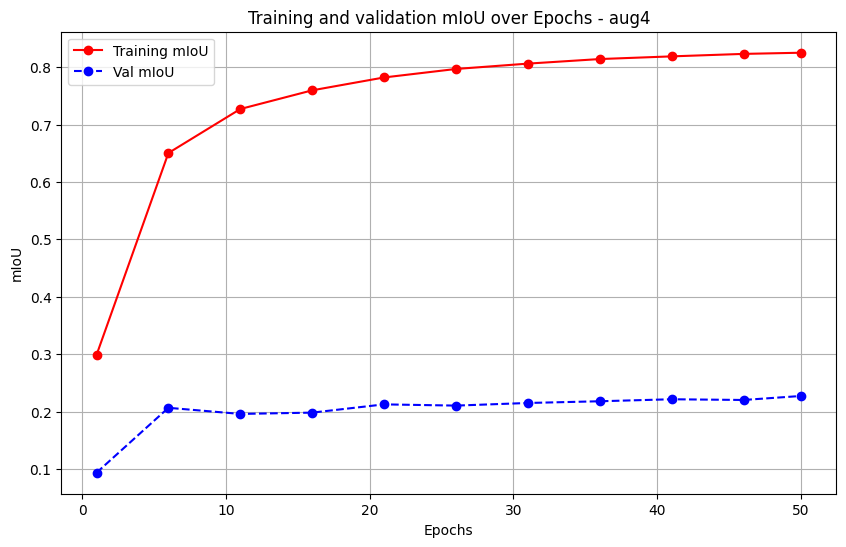

In [ ]:
# print miou evolution
epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list_aug4, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list_aug4, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs - aug4')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(miou_per_class_val_list_aug4[-1])

[5.03980912e-01 1.29224207e-01 6.55021502e-01 9.10217459e-02
 9.55601245e-02 1.60319924e-01 1.06055174e-01 5.49853491e-02
 7.61160760e-01 5.27350948e-02 6.82430807e-01 3.35991868e-01
 1.40778358e-02 4.69048365e-01 1.09383584e-01 3.10518520e-02
 3.69469503e-04 4.86548063e-02 1.45104240e-02]


In [ ]:
print(miou_per_class_train_list_aug4[-1])

[0.992037   0.91129327 0.92884718 0.88444865 0.74270011 0.60070887
 0.64003503 0.76117695 0.85852584 0.87221891 0.96352751 0.6297939
 0.69893372 0.93819956 0.94041339 0.96494901 0.9435102  0.79649411
 0.61171954]


In [ ]:
print(miou_per_class_val_list_aug4[np.argmax(np.array(miou_val_list_aug4))])

[5.03980912e-01 1.29224207e-01 6.55021502e-01 9.10217459e-02
 9.55601245e-02 1.60319924e-01 1.06055174e-01 5.49853491e-02
 7.61160760e-01 5.27350948e-02 6.82430807e-01 3.35991868e-01
 1.40778358e-02 4.69048365e-01 1.09383584e-01 3.10518520e-02
 3.69469503e-04 4.86548063e-02 1.45104240e-02]


In [ ]:
print(miou_per_class_train_list_aug4[np.argmax(np.array(miou_val_list_aug4))])

[0.992037   0.91129327 0.92884718 0.88444865 0.74270011 0.60070887
 0.64003503 0.76117695 0.85852584 0.87221891 0.96352751 0.6297939
 0.69893372 0.93819956 0.94041339 0.96494901 0.9435102  0.79649411
 0.61171954]


aug5

In [ ]:
bisenet_aug5 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

# Define optimizer
optimizer_aug5 = torch.optim.SGD(bisenet_aug5.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list_aug5 = []
miou_val_list_aug5 = []
miou_per_class_train_list_aug5 = []
miou_per_class_val_list_aug5 = []
models_aug5 = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")

    train_loss, train_miou, train_miou_per_class = train(ep, bisenet_aug5, train_dataloader5, loss_fn, optimizer_aug5)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer_aug5, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet_aug5, val_dataloader, loss_fn)
      miou_train_list_aug5.append(train_miou)
      miou_val_list_aug5.append(val_miou)
      miou_per_class_train_list_aug5.append(train_miou_per_class)
      miou_per_class_val_list_aug5.append(val_miou_per_class)
      models_aug5.append(bisenet_aug5.state_dict())

    print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet_aug5, val_dataloader, loss_fn)
miou_train_list_aug5.append(train_miou)
miou_val_list_aug5.append(val_miou)
miou_per_class_train_list_aug5.append(train_miou_per_class)
miou_per_class_val_list_aug5.append(val_miou_per_class)
models_aug5.append(bisenet_aug5.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# save best model
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3b_aug5_epoch{epochs}_batchsize8.pth'

if os.path.exists(PATH):
    os.remove(PATH) # delete old model files

best_bisenet_aug5 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet_aug5.load_state_dict(models_aug5[np.argmax(np.array(miou_val_list_aug5))])
torch.save(best_bisenet_aug5.state_dict(), PATH)

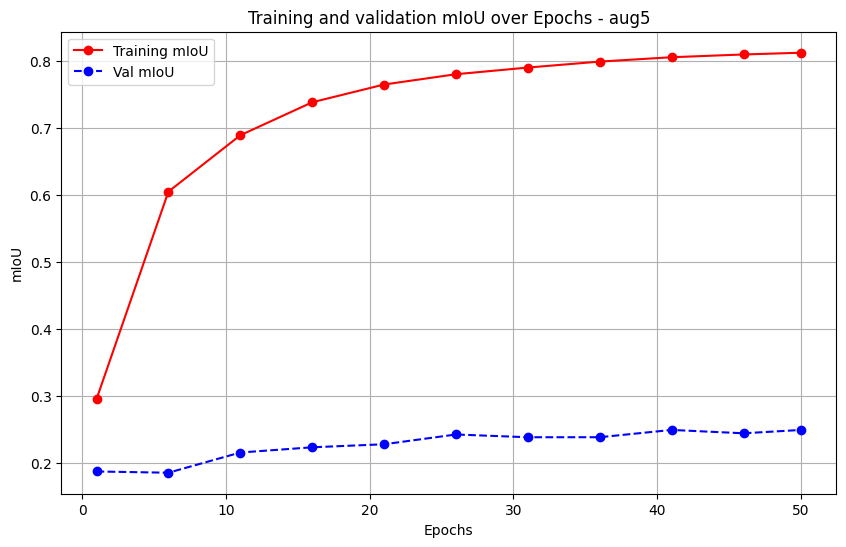

In [ ]:
# print miou evolution
epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list_aug5, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list_aug5, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs - aug5')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(miou_per_class_val_list_aug5[-1])

[0.6540344  0.06177643 0.68142169 0.09040365 0.08271441 0.18706749
 0.16243939 0.07326827 0.74423072 0.06090067 0.71779193 0.37042774
 0.03556332 0.64218023 0.08702462 0.02961464 0.         0.05617738
 0.00478603]


In [ ]:
print(miou_per_class_train_list_aug5[-1])

[0.99116874 0.90193423 0.92317525 0.870422   0.72611245 0.58910011
 0.62339683 0.74267373 0.84933311 0.86056252 0.96321523 0.60435267
 0.67012886 0.9323012  0.936427   0.96148409 0.94672076 0.77054911
 0.56840462]


In [ ]:
print(miou_per_class_val_list_aug5[np.argmax(np.array(miou_val_list_aug5))])

[0.69808006 0.04778777 0.69653213 0.08779817 0.08024189 0.18147134
 0.17532566 0.07750994 0.73794445 0.0628367  0.70517363 0.34814419
 0.02589416 0.67520712 0.08601088 0.01973037 0.         0.0322965
 0.00423299]


In [ ]:
print(miou_per_class_train_list_aug5[np.argmax(np.array(miou_val_list_aug5))])

[0.99076677 0.89808375 0.92024826 0.86248108 0.71488604 0.5823963
 0.61357078 0.73081934 0.84556845 0.85426152 0.96283276 0.59421901
 0.65193233 0.92929979 0.93234721 0.95941805 0.94331473 0.75699677
 0.56033769]


final augmentation

In [ ]:
bisenet_aug25 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)

# Define optimizer
optimizer_aug25 = torch.optim.SGD(bisenet_aug25.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# Setup training and save the results
epochs = 50

miou_train_list_aug25 = []
miou_val_list_aug25 = []
miou_per_class_train_list_aug25 = []
miou_per_class_val_list_aug25 = []
models_aug25 = []

curr_lr = initial_lr

for ep in range(epochs):

    print(f"Current learning rate: {curr_lr}")

    train_loss, train_miou, train_miou_per_class = train(ep, bisenet_aug25, train_dataloader25, loss_fn, optimizer_aug25)

    ## Inserting learning rate decay
    curr_lr = poly_lr_scheduler(optimizer = optimizer_aug25, init_lr = initial_lr, iter = ep, lr_decay_iter=1, max_iter=epochs, power=0.9)

    if ep % 5 == 0:
      val_loss, val_miou, val_miou_per_class = validation(bisenet_aug25, val_dataloader, loss_fn)
      miou_train_list_aug25.append(train_miou)
      miou_val_list_aug25.append(val_miou)
      miou_per_class_train_list_aug25.append(train_miou_per_class)
      miou_per_class_val_list_aug25.append(val_miou_per_class)
      models_aug25.append(bisenet_aug25.state_dict())

    print("\n")

# Validation after the final epoch
val_loss, val_miou, val_miou_per_class = validation(bisenet_aug25, val_dataloader, loss_fn)
miou_train_list_aug25.append(train_miou)
miou_val_list_aug25.append(val_miou)
miou_per_class_train_list_aug25.append(train_miou_per_class)
miou_per_class_val_list_aug25.append(val_miou_per_class)
models_aug25.append(bisenet_aug25.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rate: 0.025
Epoch1 Avg. Training Loss: 0.5031464799642563, mIoU: 0.27625827749093507
Avg. Validation Loss: 1.2664909839630127, mIoU: 0.1975116975168305


Current learning rate: 0.025
Epoch2 Avg. Training Loss: 0.3220598772764206, mIoU: 0.3820605740043667


Current learning rate: 0.024549546664914382
Epoch3 Avg. Training Loss: 0.27808503324985506, mIoU: 0.45385859340950363


Current learning rate: 0.024098173031463777
Epoch4 Avg. Training Loss: 0.24008992340564728, mIoU: 0.5247514929940865


Current learning rate: 0.023645857984465803
Epoch5 Avg. Training Loss: 0.21317939426898957, mIoU: 0.5686785899210035


Current learning rate: 0.023192579464083207
Epoch6 Avg. Training Loss: 0.1994333608031273, mIoU: 0.593849207760574
Avg. Validation Loss: 1.2262039384841918, mIoU: 0.2395428604384651


Current learning rate: 0.022738314402074057
Epoch7 Avg. Training Loss: 0.19316418596506119, mIoU: 0.6098449697118139


Current learning rate: 0.022283038652225
Epoch8 Avg. Training Los

In [ ]:
# save best model
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'bisenet3b_aug25_epoch{epochs}.pth'

if os.path.exists(PATH):
    os.remove(PATH) # delete old model files

best_bisenet_aug25 = BiSeNet(num_classes = 19, context_path='resnet18').to(device)
best_bisenet_aug25.load_state_dict(models_aug25[np.argmax(np.array(miou_val_list_aug25))])
torch.save(best_bisenet_aug25.state_dict(), PATH)

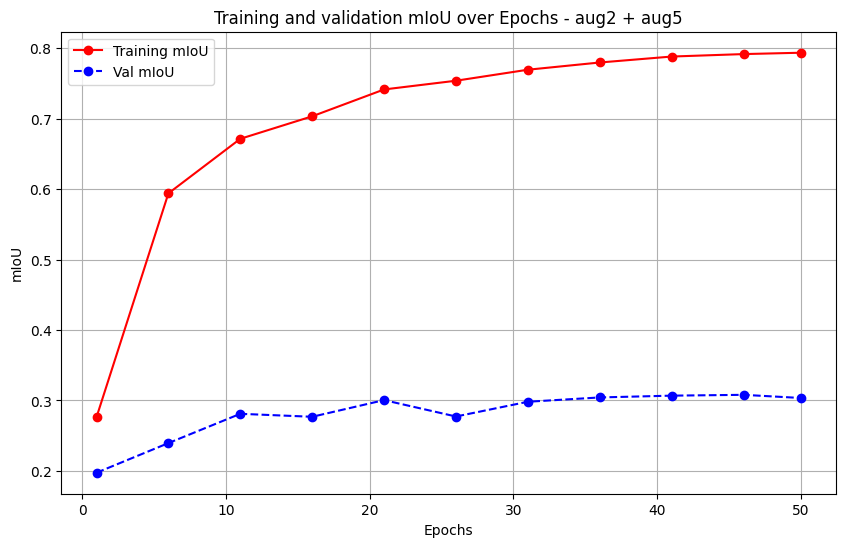

In [ ]:
import matplotlib.pyplot as plt
# print miou evolution
epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list_aug25, marker='o', linestyle='-', color='r', label='Training mIoU')
plt.plot(epochs_list, miou_val_list_aug25, marker='o', linestyle='--', color='b', label='Val mIoU')

plt.title('Training and validation mIoU over Epochs - aug2 + aug5')
plt.xlabel('Epochs')
plt.ylabel('mIoU')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(miou_per_class_val_list_aug25[-1])

[8.18841146e-01 1.89061606e-01 7.39516347e-01 2.13977593e-01
 8.95085991e-02 2.06797782e-01 1.34716125e-01 5.90577246e-02
 7.78485626e-01 2.11569635e-01 8.37531107e-01 4.17972654e-01
 7.81465859e-02 6.23536039e-01 1.46210692e-01 1.00540409e-01
 8.36778706e-04 6.83584605e-02 5.22351041e-02]


In [ ]:
print(miou_per_class_train_list_aug25[-1])

[0.98981988 0.88902863 0.91337398 0.85156245 0.70207448 0.5678063
 0.5880401  0.71427955 0.83570209 0.8396263  0.95920261 0.58475695
 0.62115659 0.92354029 0.92520369 0.95256553 0.94144098 0.73796266
 0.53729827]


In [ ]:
print(miou_per_class_val_list_aug25[np.argmax(np.array(miou_val_list_aug25))])

[8.37630208e-01 2.05291384e-01 7.43387421e-01 2.14581169e-01
 8.99499197e-02 1.93405247e-01 1.44331493e-01 6.22764149e-02
 7.78852053e-01 2.23174587e-01 8.37754533e-01 4.23974460e-01
 7.29620000e-02 6.66701619e-01 1.24936524e-01 1.14976308e-01
 1.24527832e-04 6.99750951e-02 4.82580319e-02]


In [ ]:
print(miou_per_class_train_list_aug25[np.argmax(np.array(miou_val_list_aug25))])

[0.9894644  0.88604954 0.91169243 0.84632867 0.69903962 0.56400019
 0.58247932 0.70985592 0.833481   0.83437096 0.95874604 0.58063204
 0.63173515 0.9214669  0.92317865 0.95568674 0.93588698 0.74498677
 0.52865121]
